# Comprehensive EDA: AI Salary Data Analysis

This notebook performs exploratory data analysis on all data sources to identify the most valuable features for salary prediction.

## Data Sources:
1. **H1B Visa Salaries** - Government-reported AI salaries from H1B applications
2. **BLS Wage Data** - Bureau of Labor Statistics wage statistics
3. **Adzuna Job Postings** - Job board salary data
4. **LinkedIn Job Postings** - LinkedIn job postings with salary ranges and skills

## Analysis Goals:
- Assess data quality and completeness
- Identify key features that correlate with salary
- Understand feature distributions and relationships
- Determine which data sources provide the most value

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. Load Data from All Sources

In [15]:
# Load data from S3 backup
data_dir = Path('../s3_data_backup/data/raw/parquet')

# Load each source
h1b_df = pd.read_parquet(data_dir / 'h1b_ai_salaries.parquet')
bls_df = pd.read_parquet(data_dir / 'bls_wage_data.parquet')
adzuna_df = pd.read_parquet(data_dir / 'adzuna_jobs.parquet')
linkedin_df = pd.read_parquet(data_dir / 'linkedin_ai_jobs.parquet')

# Also load the merged data if available
merged_path = Path('../s3_data_backup/data/processed/merged_salary_data.parquet')
if merged_path.exists():
    merged_df = pd.read_parquet(merged_path)
else:
    merged_df = None

print(f"H1B Data: {len(h1b_df):,} records")
print(f"BLS Data: {len(bls_df):,} records")
print(f"Adzuna Data: {len(adzuna_df):,} records")
print(f"LinkedIn Data: {len(linkedin_df):,} records")
if merged_df is not None:
    print(f"\nMerged Data: {len(merged_df):,} records")

H1B Data: 10,000 records
BLS Data: 7 records
Adzuna Data: 16,512 records
LinkedIn Data: 964 records

Merged Data: 21,933 records


## 2. Data Quality Assessment

In [16]:
def assess_data_quality(df, name):
    """Assess data quality for a dataframe."""
    print(f"\n{'='*60}")
    print(f"{name} - Data Quality Report")
    print(f"{'='*60}")
    
    print(f"\nShape: {df.shape}")
    print(f"\nColumn Names:\n{list(df.columns)}")
    
    # Missing data
    print(f"\nMissing Data:")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(2)
    missing_df = pd.DataFrame({
        'Missing': missing,
        'Percentage': missing_pct
    }).sort_values('Missing', ascending=False)
    print(missing_df[missing_df['Missing'] > 0].head(10))
    
    # Data types
    print(f"\nData Types:")
    print(df.dtypes.value_counts())
    
    # Basic statistics for numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(f"\nNumeric Column Statistics:")
        print(df[numeric_cols].describe().T)
    
    return missing_df

# Assess each data source
h1b_quality = assess_data_quality(h1b_df, "H1B Data")
bls_quality = assess_data_quality(bls_df, "BLS Data")
adzuna_quality = assess_data_quality(adzuna_df, "Adzuna Data")
linkedin_quality = assess_data_quality(linkedin_df, "LinkedIn Data")


H1B Data - Data Quality Report

Shape: (10000, 17)

Column Names:
['case_number', 'case_status', 'received_date', 'employer_name', 'employer_city', 'employer_state', 'job_title', 'soc_code', 'soc_title', 'wage_from', 'wage_to', 'wage_unit', 'worksite_city', 'worksite_state', 'prevailing_wage', 'fiscal_year', 'annual_salary']

Missing Data:
Empty DataFrame
Columns: [Missing, Percentage]
Index: []

Data Types:
object     12
float64     4
int64       1
Name: count, dtype: int64

Numeric Column Statistics:
                   count         mean           std       min        25%  \
wage_from        10000.0  290043.2050  71947.280756  153163.0  234709.00   
wage_to          10000.0  319047.5297  79142.014182  168479.0  258180.00   
prevailing_wage  10000.0  246536.7299  61155.187745  130188.0  199502.75   
fiscal_year      10000.0    2023.5000      0.500025    2023.0    2023.00   
annual_salary    10000.0  290043.2050  71947.280756  153163.0  234709.00   

                      50%       75

## 3. Salary Distribution Analysis

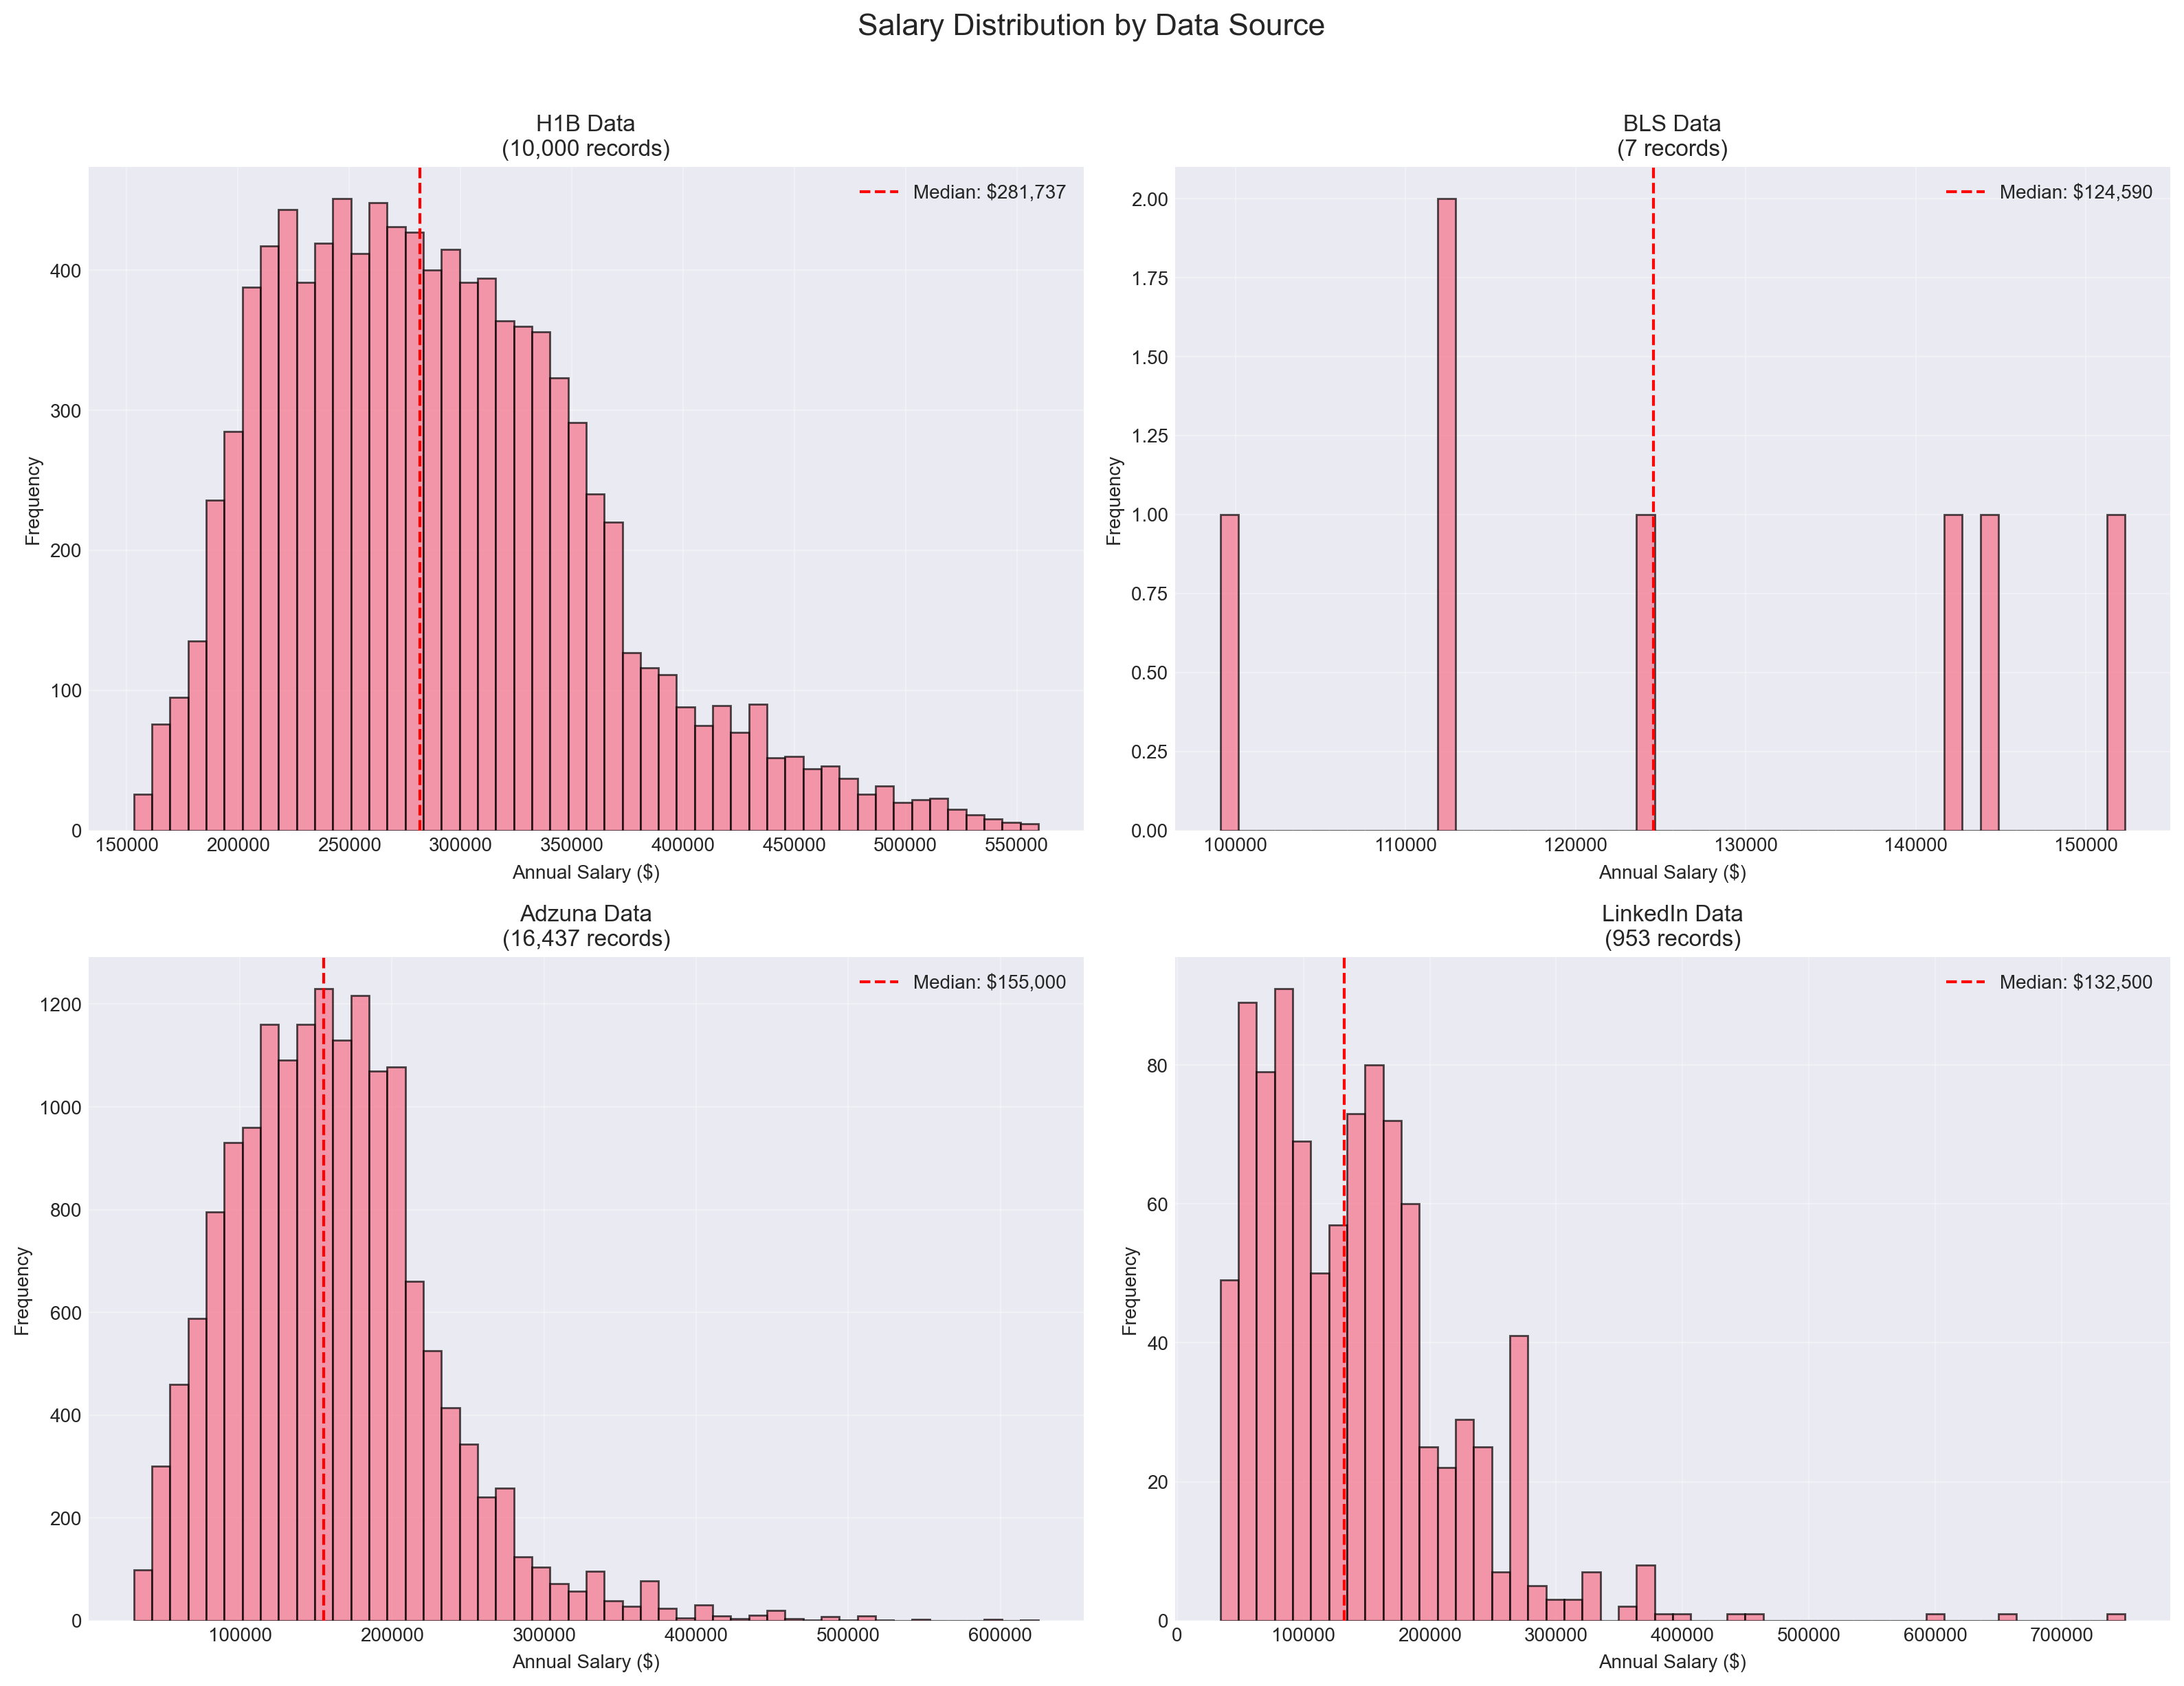


Salary Statistics by Data Source:
                 count           mean    median           std        min       max       q25        q75
H1B Data       10000.0  290043.205000  281737.0  71947.280756  153163.00  559719.0  234709.0  334206.00
BLS Data           7.0  126785.714286  124590.0  20072.688623   99120.00  152310.0  112145.0  143595.00
Adzuna Data    16437.0  160651.106561  155000.0  66752.531502   30172.72  625000.0  113235.2  198992.64
LinkedIn Data    953.0  140543.886716  132500.0  78499.729930   34320.00  750000.0   78000.0  177850.00


In [17]:
# Find salary columns in each dataset
def get_salary_column(df):
    """Detect the salary column name."""
    salary_cols = ['annual_salary', 'salary', 'wage', 'mean_annual_wage', 'salary_avg']
    for col in salary_cols:
        if col in df.columns:
            return col
    return None

# Create salary distribution comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Salary Distribution by Data Source', fontsize=16, y=1.02)

datasets = [
    (h1b_df, 'H1B Data', axes[0, 0]),
    (bls_df, 'BLS Data', axes[0, 1]),
    (adzuna_df, 'Adzuna Data', axes[1, 0]),
    (linkedin_df, 'LinkedIn Data', axes[1, 1])
]

salary_stats = {}

for df, name, ax in datasets:
    salary_col = get_salary_column(df)
    if salary_col and salary_col in df.columns:
        # Filter valid salaries
        salaries = df[df[salary_col].notna() & 
                     (df[salary_col] >= 30000) & 
                     (df[salary_col] <= 1000000)][salary_col]
        
        if len(salaries) > 0:
            # Plot distribution
            salaries.hist(bins=50, ax=ax, edgecolor='black', alpha=0.7)
            ax.set_title(f'{name}\n({len(salaries):,} records)')
            ax.set_xlabel('Annual Salary ($)')
            ax.set_ylabel('Frequency')
            ax.axvline(salaries.median(), color='red', linestyle='--', label=f'Median: ${salaries.median():,.0f}')
            ax.legend()
            ax.grid(alpha=0.3)
            
            # Store statistics
            salary_stats[name] = {
                'count': len(salaries),
                'mean': salaries.mean(),
                'median': salaries.median(),
                'std': salaries.std(),
                'min': salaries.min(),
                'max': salaries.max(),
                'q25': salaries.quantile(0.25),
                'q75': salaries.quantile(0.75)
            }
    else:
        ax.text(0.5, 0.5, 'No salary data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(name)

plt.tight_layout()
plt.show()

# Display salary statistics table
print("\nSalary Statistics by Data Source:")
stats_df = pd.DataFrame(salary_stats).T
print(stats_df.to_string())

## 4. Feature Availability Analysis

Analyze which features are available in each data source and their completeness.


Feature Availability Matrix (% Completeness):
                     H1B     BLS  Adzuna LinkedIn
job_title         100.0%     N/A     N/A   100.0%
employer_name     100.0%     N/A     N/A   100.0%
company              N/A     N/A  100.0%      N/A
location             N/A     N/A  100.0%      N/A
worksite_state    100.0%     N/A     N/A    69.2%
state                N/A     N/A  100.0%      N/A
skills               N/A     N/A     N/A   100.0%
seniority_level      N/A     N/A     N/A    99.9%
experience_years     N/A     N/A     N/A      N/A
estimated_yoe        N/A     N/A     N/A    55.2%
education            N/A     N/A     N/A    99.9%
employment_type      N/A     N/A     N/A    99.9%
job_function         N/A     N/A     N/A    99.9%
industries           N/A     N/A     N/A    99.9%
soc_code          100.0%  100.0%     N/A      N/A
year                 N/A  100.0%  100.0%   100.0%


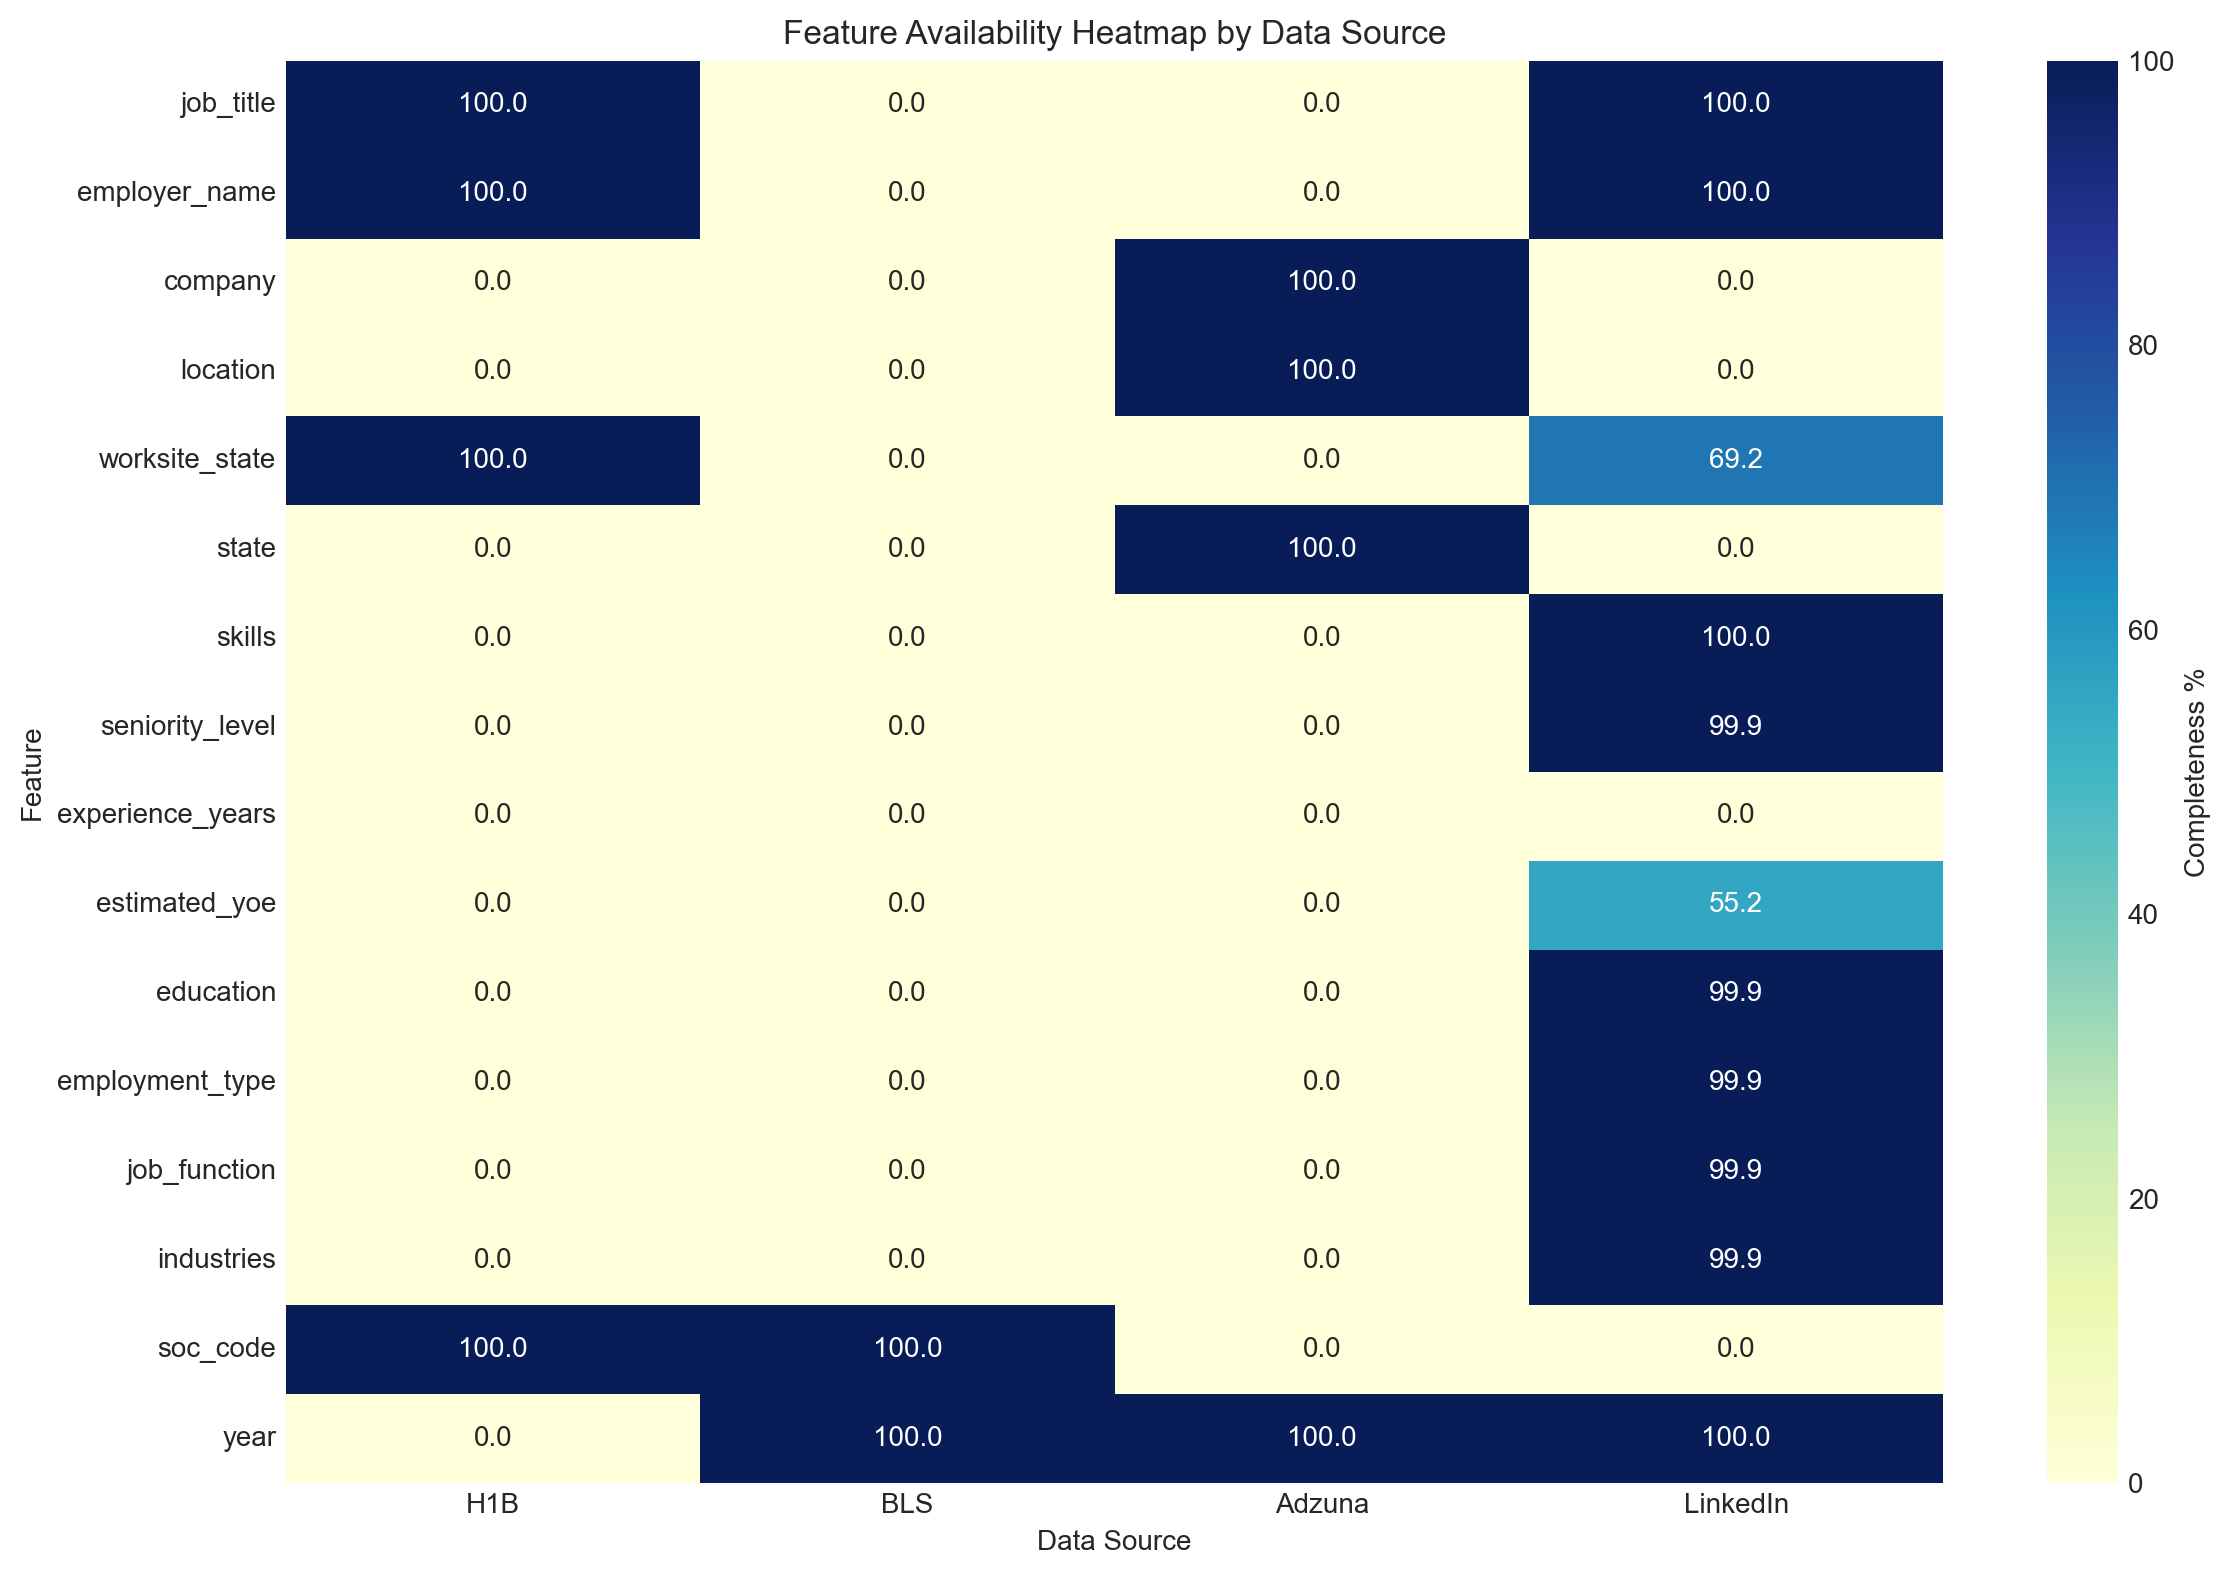

In [18]:
# Key features we're interested in
key_features = [
    'job_title', 'employer_name', 'company', 'location', 'worksite_state', 'state',
    'skills', 'seniority_level', 'experience_years', 'estimated_yoe',
    'education', 'employment_type', 'job_function', 'industries',
    'soc_code', 'year'
]

def analyze_feature_availability(df, name):
    """Analyze which key features are available and their completeness."""
    available_features = {}
    
    for feature in key_features:
        if feature in df.columns:
            non_null_count = df[feature].notna().sum()
            completeness = (non_null_count / len(df) * 100)
            available_features[feature] = {
                'available': True,
                'completeness': completeness,
                'count': non_null_count
            }
    
    return available_features

# Analyze each dataset
h1b_features = analyze_feature_availability(h1b_df, 'H1B')
bls_features = analyze_feature_availability(bls_df, 'BLS')
adzuna_features = analyze_feature_availability(adzuna_df, 'Adzuna')
linkedin_features = analyze_feature_availability(linkedin_df, 'LinkedIn')

# Create feature availability matrix
feature_matrix = pd.DataFrame(index=key_features)

for name, features in [('H1B', h1b_features), ('BLS', bls_features), 
                       ('Adzuna', adzuna_features), ('LinkedIn', linkedin_features)]:
    feature_matrix[name] = feature_matrix.index.map(
        lambda x: f"{features[x]['completeness']:.1f}%" if x in features else "N/A"
    )

print("\nFeature Availability Matrix (% Completeness):")
print(feature_matrix.to_string())

# Visualize feature availability
fig, ax = plt.subplots(figsize=(12, 8))

# Create numeric matrix for heatmap
numeric_matrix = pd.DataFrame(index=key_features)
for name, features in [('H1B', h1b_features), ('BLS', bls_features), 
                       ('Adzuna', adzuna_features), ('LinkedIn', linkedin_features)]:
    numeric_matrix[name] = numeric_matrix.index.map(
        lambda x: features[x]['completeness'] if x in features else 0
    )

sns.heatmap(numeric_matrix, annot=True, fmt='.1f', cmap='YlGnBu', 
            cbar_kws={'label': 'Completeness %'}, ax=ax)
ax.set_title('Feature Availability Heatmap by Data Source')
ax.set_xlabel('Data Source')
ax.set_ylabel('Feature')
plt.tight_layout()
plt.show()

## 5. LinkedIn Deep Dive: Skills Analysis

LinkedIn data is unique in having structured skills information. Let's analyze this.

In [19]:
# Analyze skills if available
if 'skills' in linkedin_df.columns:
    print("Skills Analysis from LinkedIn Data")
    print("="*60)
    
    # Count records with skills
    has_skills = linkedin_df['skills'].notna().sum()
    print(f"\nRecords with skills: {has_skills:,} ({has_skills/len(linkedin_df)*100:.1f}%)")
    
    # Parse skills and count frequency
    skills_counter = {}
    salary_by_skill = {}
    
    salary_col = get_salary_column(linkedin_df)
    
    for idx, row in linkedin_df.iterrows():
        if pd.notna(row['skills']) and isinstance(row['skills'], list):
            for skill in row['skills']:
                skill_lower = str(skill).lower().strip()
                if skill_lower:
                    skills_counter[skill_lower] = skills_counter.get(skill_lower, 0) + 1
                    
                    # Track salaries for this skill
                    if salary_col and pd.notna(row[salary_col]):
                        salary = row[salary_col]
                        if 30000 <= salary <= 1000000:
                            if skill_lower not in salary_by_skill:
                                salary_by_skill[skill_lower] = []
                            salary_by_skill[skill_lower].append(salary)
    
    # Top skills by frequency
    top_skills = sorted(skills_counter.items(), key=lambda x: x[1], reverse=True)[:30]
    
    print(f"\nTop 30 Most Common Skills:")
    for i, (skill, count) in enumerate(top_skills, 1):
        median_salary = np.median(salary_by_skill.get(skill, [0]))
        print(f"{i:2d}. {skill:30s} - {count:4d} jobs (Median Salary: ${median_salary:,.0f})")
    
    # Plot top skills
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Frequency plot
    skills_df = pd.DataFrame(top_skills[:20], columns=['Skill', 'Count'])
    skills_df.set_index('Skill')['Count'].plot(kind='barh', ax=axes[0])
    axes[0].set_title('Top 20 Skills by Frequency')
    axes[0].set_xlabel('Number of Job Postings')
    axes[0].invert_yaxis()
    
    # Salary by skill plot
    skill_salary_data = [(skill, np.median(salaries)) 
                         for skill, salaries in salary_by_skill.items() 
                         if len(salaries) >= 10]  # At least 10 samples
    skill_salary_data = sorted(skill_salary_data, key=lambda x: x[1], reverse=True)[:20]
    
    if skill_salary_data:
        salary_df = pd.DataFrame(skill_salary_data, columns=['Skill', 'Median Salary'])
        salary_df.set_index('Skill')['Median Salary'].plot(kind='barh', ax=axes[1], color='green')
        axes[1].set_title('Top 20 Highest-Paying Skills (≥10 samples)')
        axes[1].set_xlabel('Median Salary ($)')
        axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
else:
    print("No skills data available in LinkedIn dataset")

Skills Analysis from LinkedIn Data

Records with skills: 964 (100.0%)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## 6. Geographic Analysis

Analyze salary variations by location.

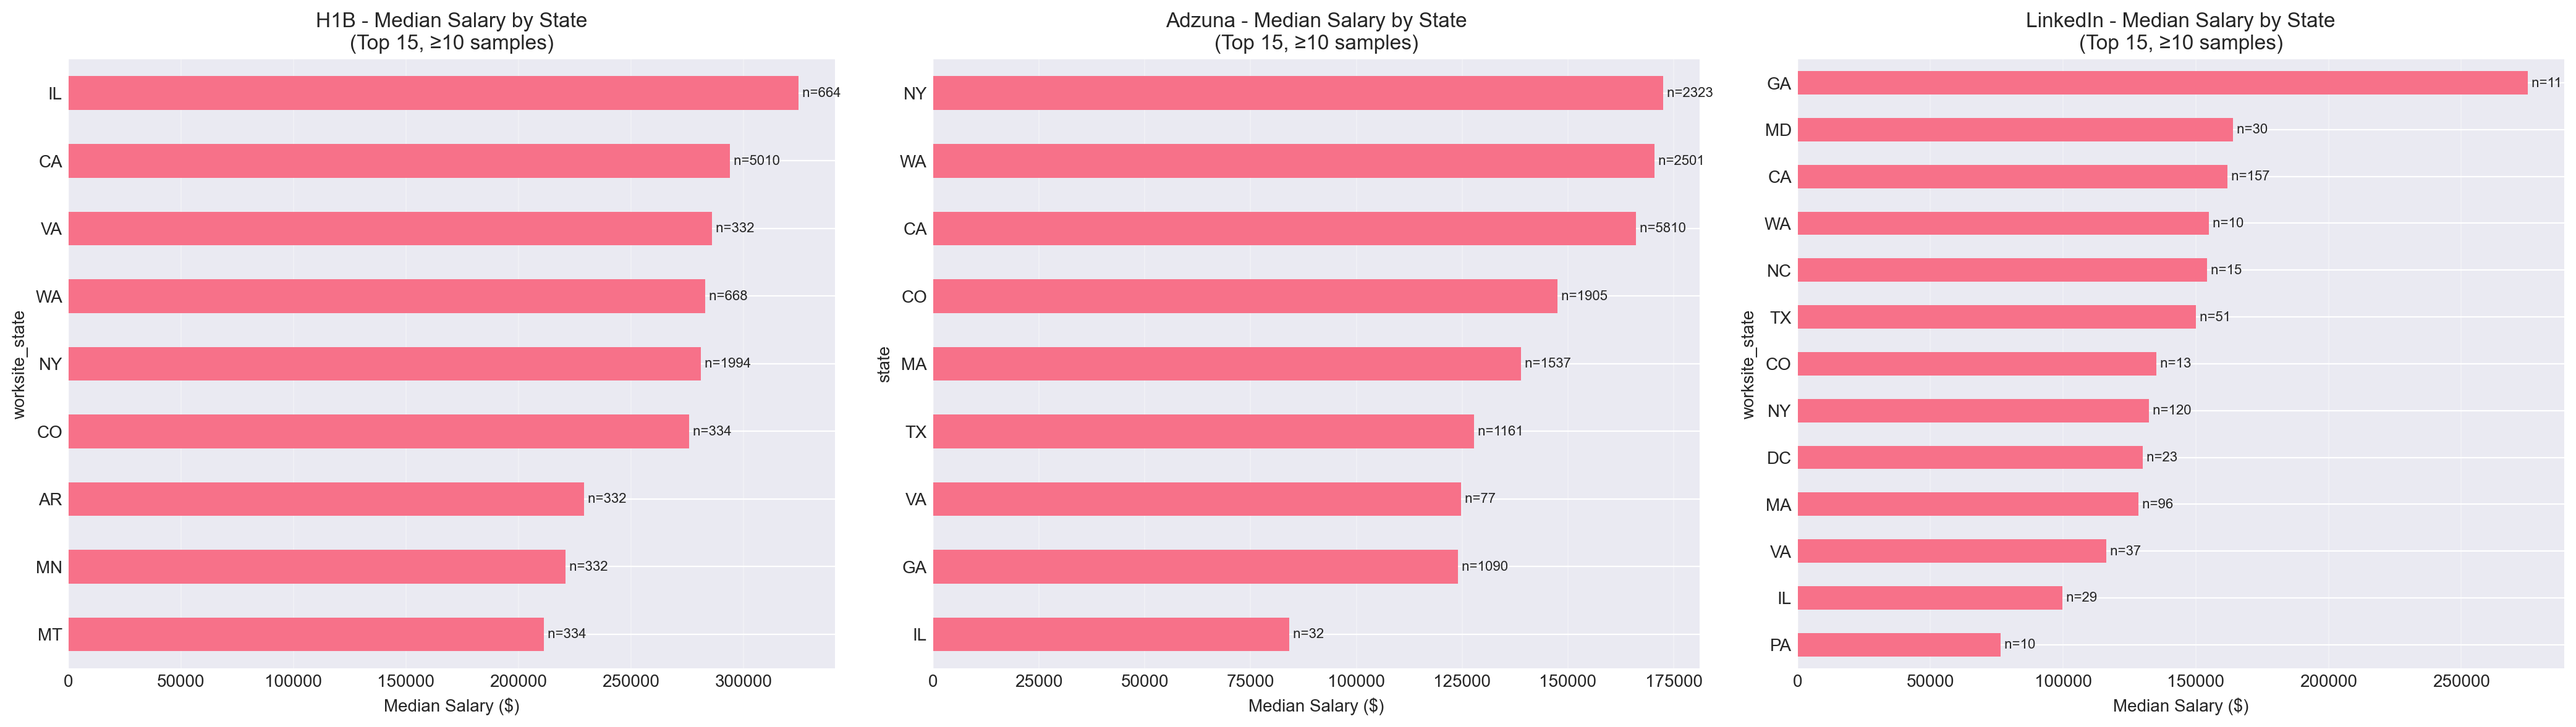


H1B - Location Statistics:
                count    median           mean            std
worksite_state                                               
IL                664  324393.0  326088.399096   69347.185157
CA               5010  293984.0  301087.463673   72210.803216
VA                332  286021.0  284561.084337   50085.540333
WA                668  283053.5  311234.175150  106601.359805
NY               1994  281011.0  281263.678034   51754.883862
CO                334  275904.0  273198.203593   43952.977099
AR                332  229007.0  231606.909639   37791.849173
MN                332  220891.0  220195.671687   36461.291068
MT                334  211136.5  212562.934132   32714.620039

Adzuna - Location Statistics:
       count      median           mean           std
state                                                
NY      2323  172477.730  171458.627064  62859.911590
WA      2501  170506.520  167733.510196  60094.041186
CA      5810  166041.070  173687.577959  75

In [ ]:
# Analyze by state/location
def analyze_by_location(df, name, location_col, salary_col):
    """Analyze salary by location."""
    if location_col not in df.columns or salary_col not in df.columns:
        return None
    
    # Filter valid data
    valid_data = df[(df[location_col].notna()) & 
                    (df[salary_col].notna()) &
                    (df[salary_col] >= 30000) &
                    (df[salary_col] <= 1000000)].copy()
    
    if len(valid_data) == 0:
        return None
    
    # Group by location
    location_stats = valid_data.groupby(location_col)[salary_col].agg([
        ('count', 'count'),
        ('median', 'median'),
        ('mean', 'mean'),
        ('std', 'std')
    ]).sort_values('median', ascending=False)
    
    # Filter locations with at least 10 samples
    location_stats = location_stats[location_stats['count'] >= 10]
    
    return location_stats

# Try to find location columns
location_analyses = []

for df, name in [(h1b_df, 'H1B'), (adzuna_df, 'Adzuna'), (linkedin_df, 'LinkedIn')]:
    salary_col = get_salary_column(df)
    if salary_col:
        # Try different location column names
        for loc_col in ['worksite_state', 'state', 'location_state']:
            if loc_col in df.columns:
                stats = analyze_by_location(df, name, loc_col, salary_col)
                if stats is not None and len(stats) > 0:
                    location_analyses.append((name, stats))
                    break

# Plot location analysis
if location_analyses:
    n_sources = len(location_analyses)
    fig, axes = plt.subplots(1, n_sources, figsize=(7*n_sources, 6))
    if n_sources == 1:
        axes = [axes]
    
    for (name, stats), ax in zip(location_analyses, axes):
        top_locations = stats.head(15)
        top_locations['median'].plot(kind='barh', ax=ax)
        ax.set_title(f'{name} - Median Salary by State\n(Top 15, ≥10 samples)')
        ax.set_xlabel('Median Salary ($)')
        ax.invert_yaxis()
        ax.grid(axis='x', alpha=0.3)
        
        # Add count annotations
        for i, (idx, row) in enumerate(top_locations.iterrows()):
            ax.text(row['median'], i, f" n={int(row['count'])}", 
                   va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed stats
    for name, stats in location_analyses:
        print(f"\n{name} - Location Statistics:")
        print(stats.head(10).to_string())
else:
    print("No location data available for analysis")

## 7. Job Title Analysis

Analyze salary variations by job title/role.

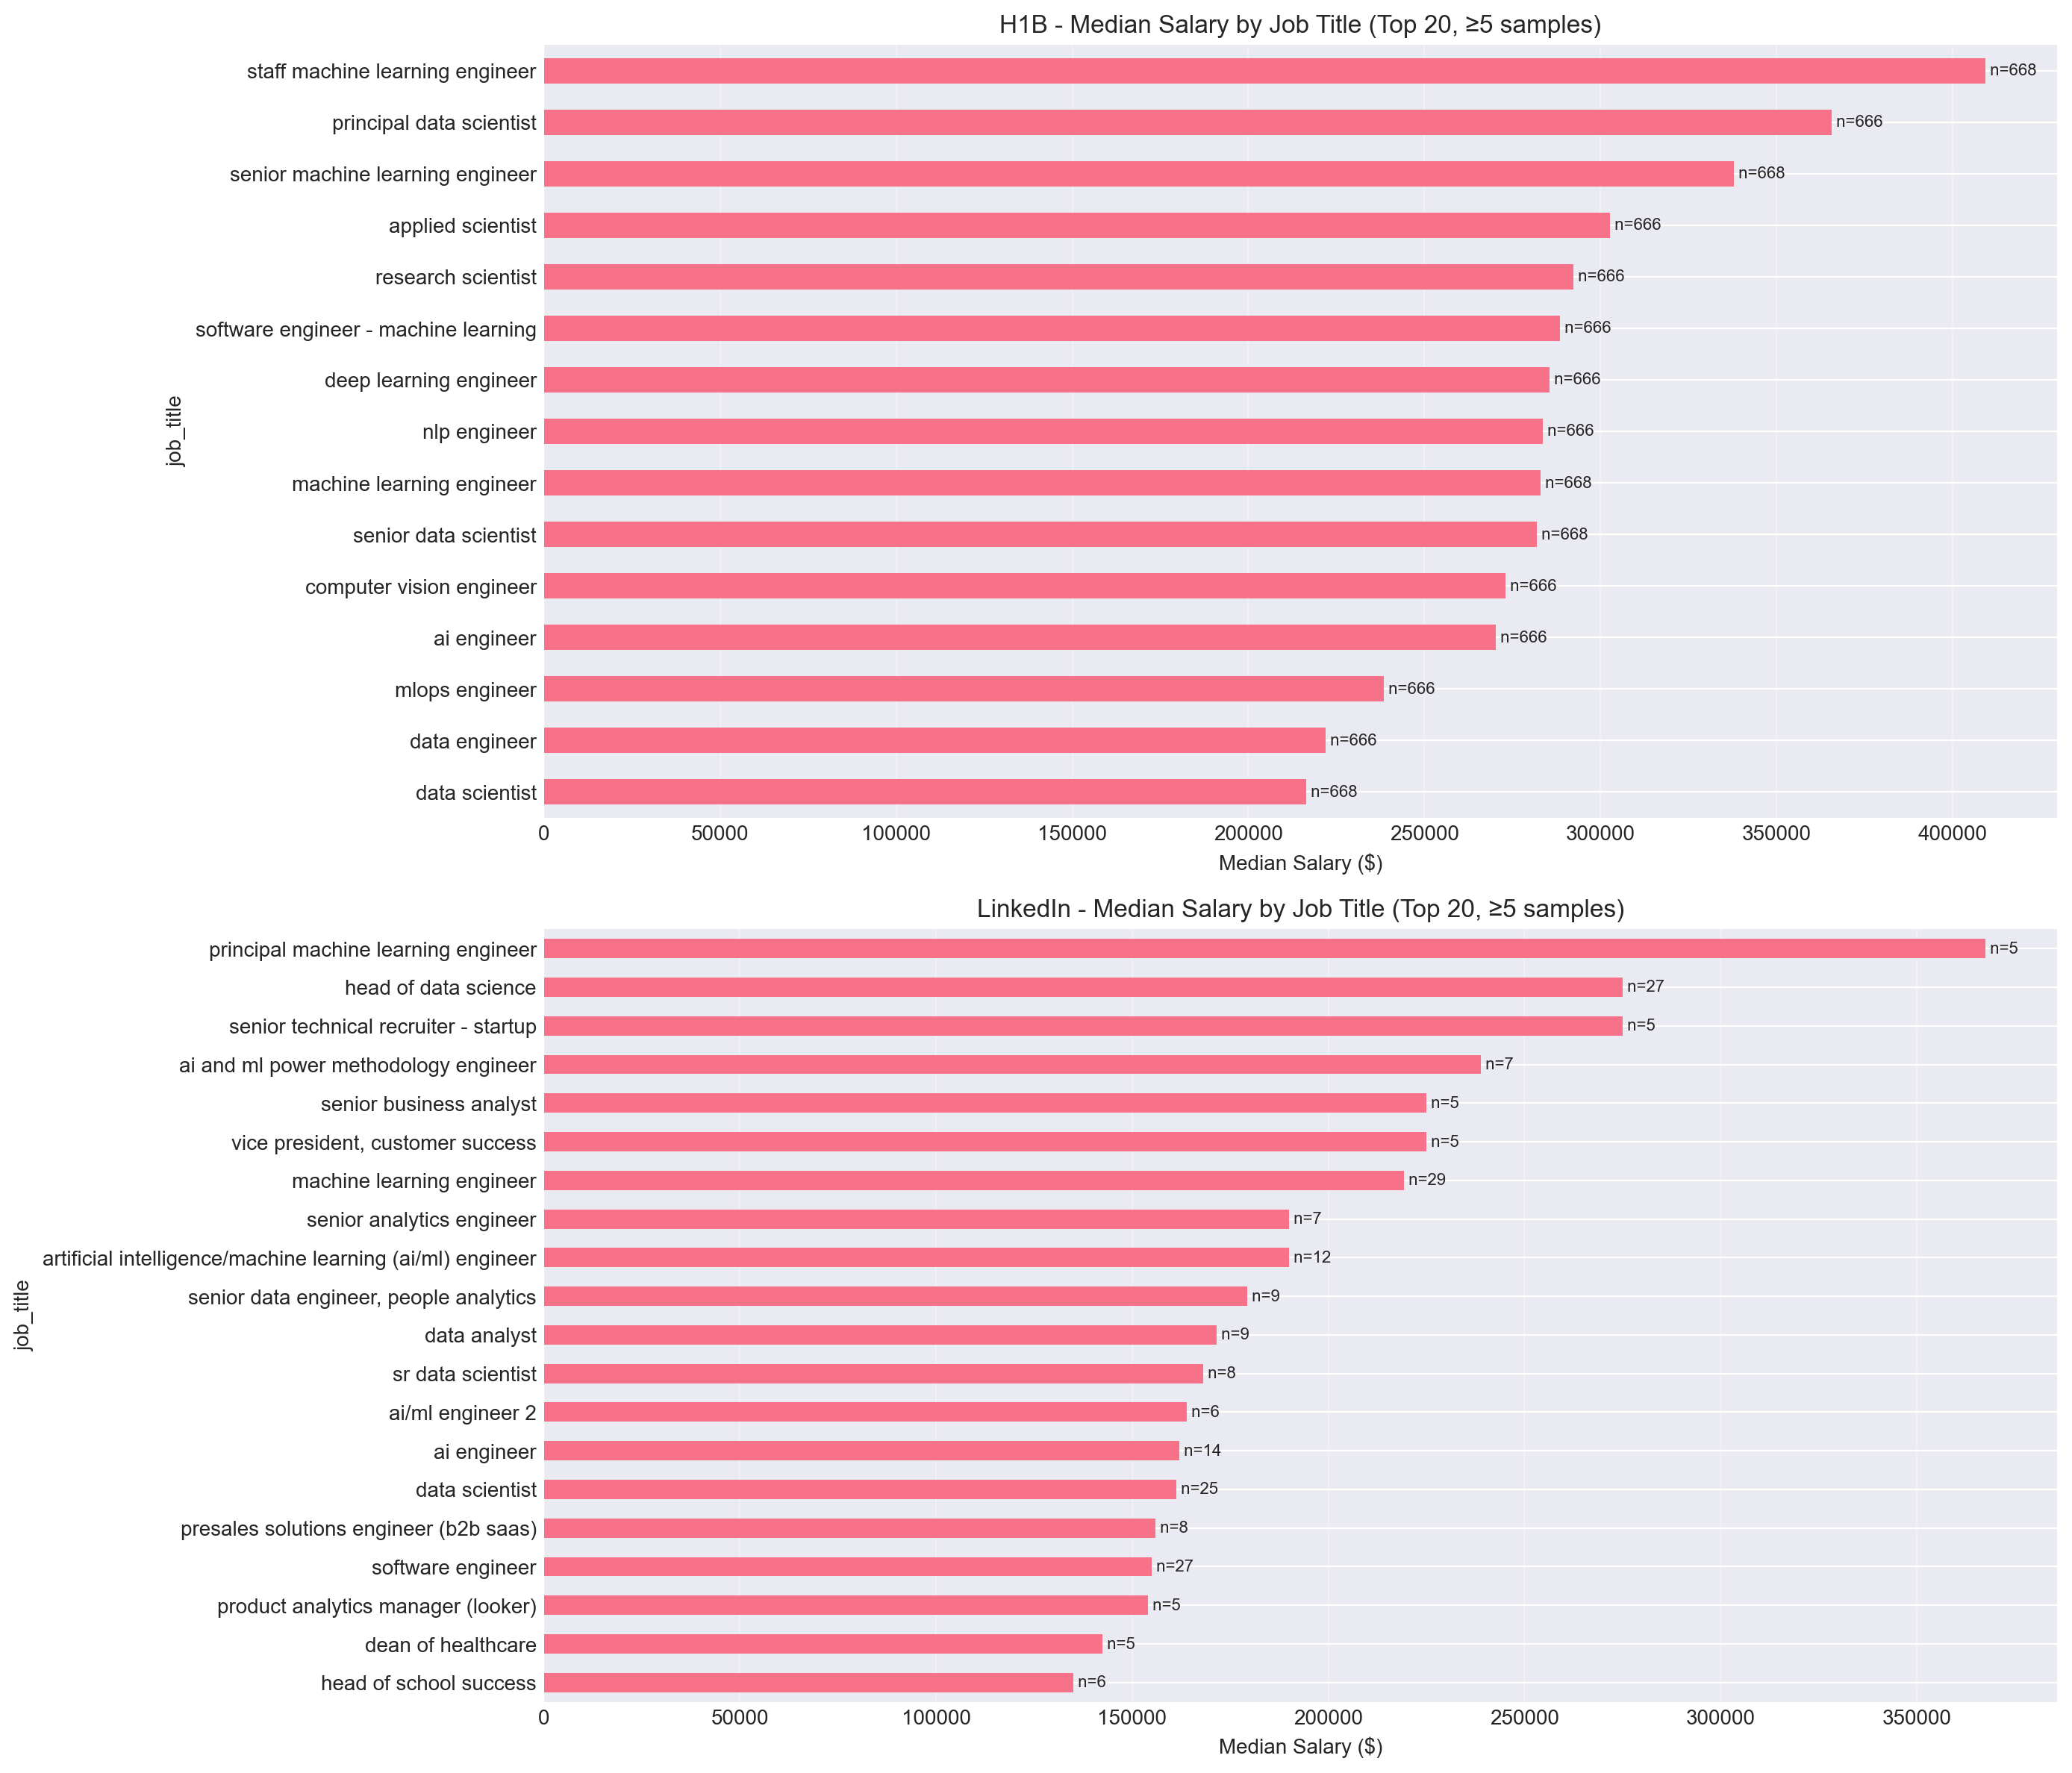

In [20]:
def analyze_job_titles(df, name, title_col, salary_col, top_n=20):
    """Analyze salaries by job title."""
    if title_col not in df.columns or salary_col not in df.columns:
        return None
    
    # Filter valid data
    valid_data = df[(df[title_col].notna()) & 
                    (df[salary_col].notna()) &
                    (df[salary_col] >= 30000) &
                    (df[salary_col] <= 1000000)].copy()
    
    if len(valid_data) == 0:
        return None
    
    # Clean job titles (convert to lowercase, strip)
    valid_data[title_col] = valid_data[title_col].str.lower().str.strip()
    
    # Group by title
    title_stats = valid_data.groupby(title_col)[salary_col].agg([
        ('count', 'count'),
        ('median', 'median'),
        ('mean', 'mean')
    ]).sort_values('median', ascending=False)
    
    # Filter titles with at least 5 samples
    title_stats = title_stats[title_stats['count'] >= 5]
    
    return title_stats.head(top_n)

# Analyze job titles from each source
h1b_titles = analyze_job_titles(h1b_df, 'H1B', 'job_title', get_salary_column(h1b_df))
adzuna_titles = analyze_job_titles(adzuna_df, 'Adzuna', 'job_title', get_salary_column(adzuna_df))
linkedin_titles = analyze_job_titles(linkedin_df, 'LinkedIn', 'job_title', get_salary_column(linkedin_df))

# Plot
title_analyses = [(df, name) for df, name in 
                  [(h1b_titles, 'H1B'), (adzuna_titles, 'Adzuna'), (linkedin_titles, 'LinkedIn')] 
                  if df is not None]

if title_analyses:
    n_sources = len(title_analyses)
    fig, axes = plt.subplots(n_sources, 1, figsize=(14, 6*n_sources))
    if n_sources == 1:
        axes = [axes]
    
    for (stats, name), ax in zip(title_analyses, axes):
        stats['median'].plot(kind='barh', ax=ax)
        ax.set_title(f'{name} - Median Salary by Job Title (Top 20, ≥5 samples)')
        ax.set_xlabel('Median Salary ($)')
        ax.invert_yaxis()
        ax.grid(axis='x', alpha=0.3)
        
        # Add count annotations
        for i, (idx, row) in enumerate(stats.iterrows()):
            ax.text(row['median'], i, f" n={int(row['count'])}", 
                   va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
else:
    print("No job title data available for analysis")

## 8. Merged Dataset Analysis

If we have merged data, analyze the combined dataset.


Merged Dataset Analysis

Records by Data Source:
data_source
job_posting    11427
h1b             9996
linkedin         503
bls                7
Name: count, dtype: int64


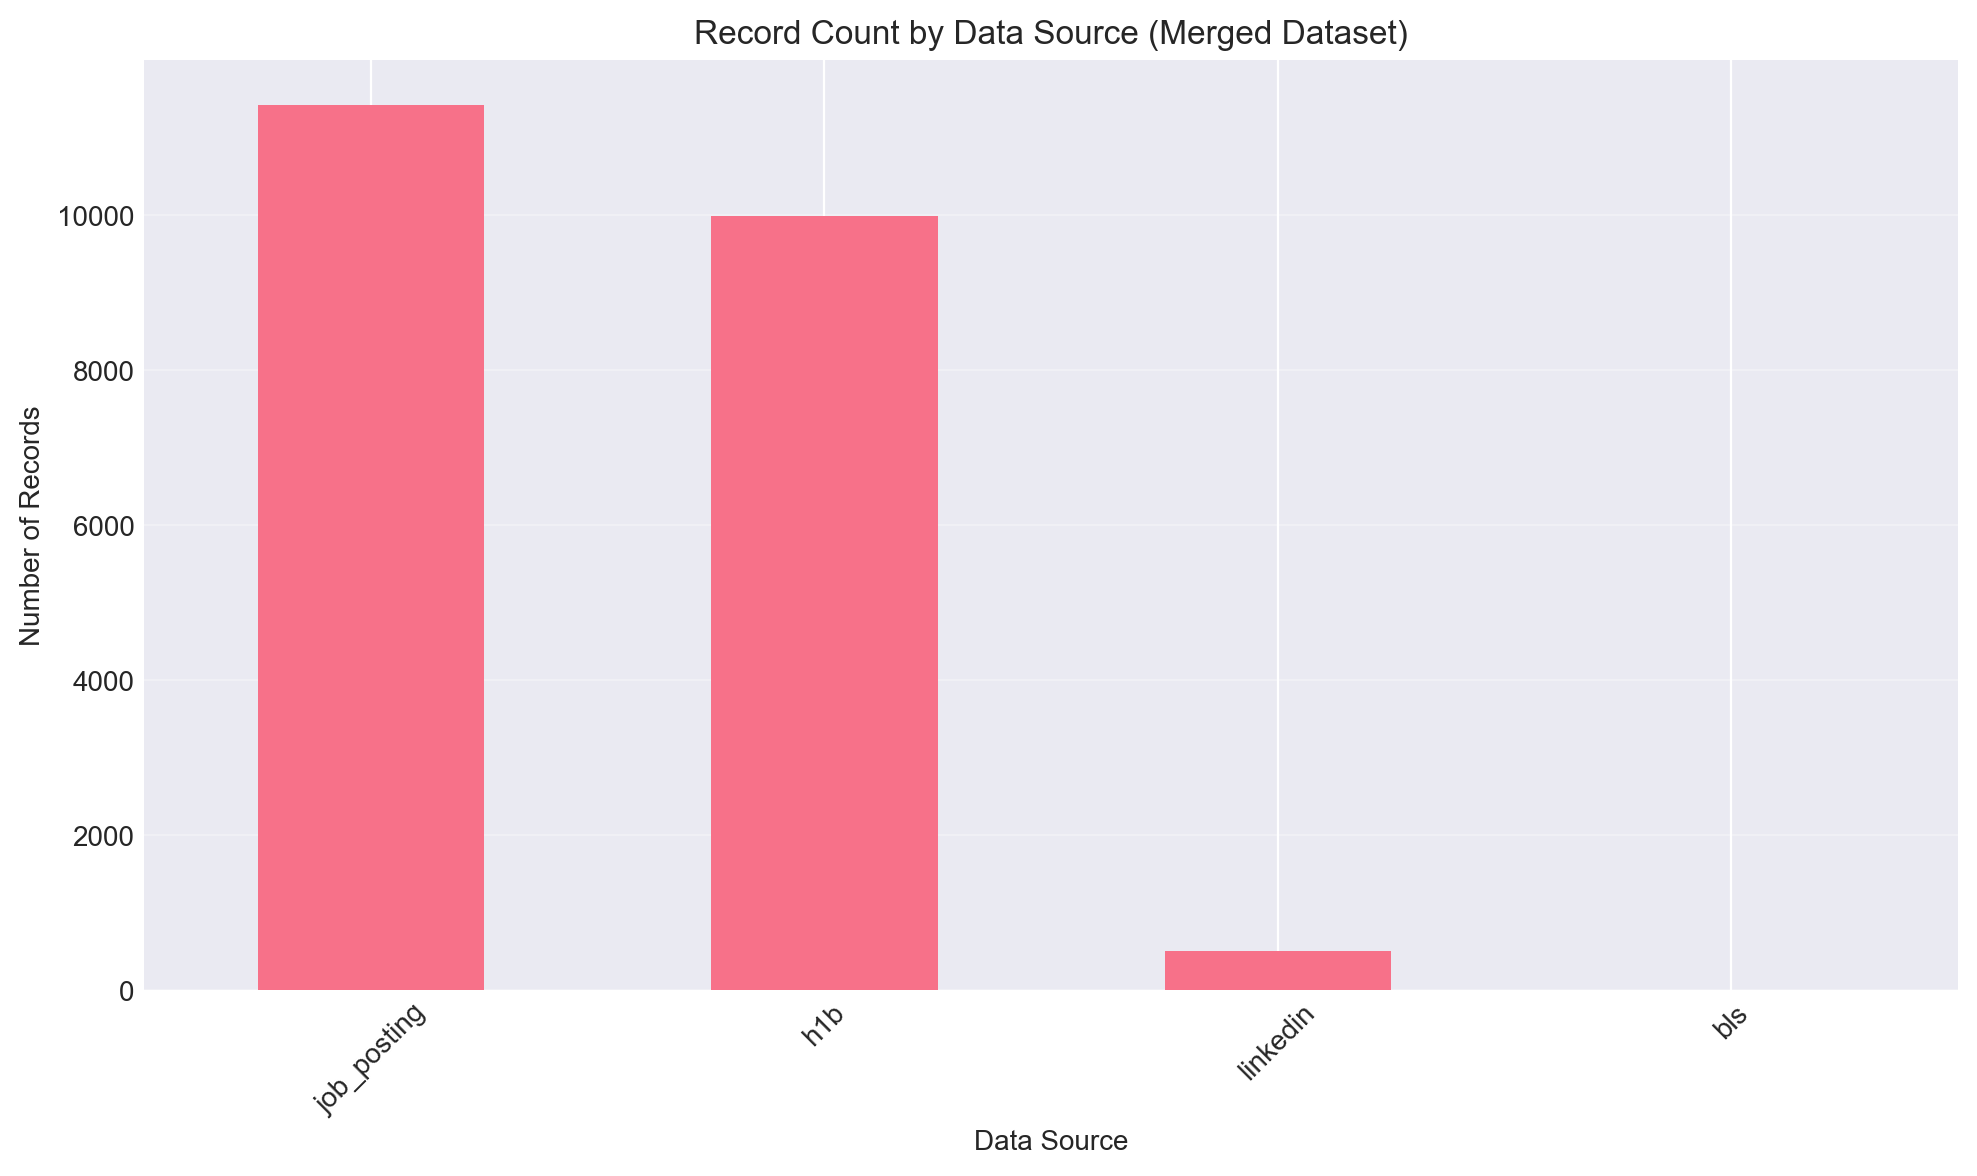


Merged Dataset - Data Quality Report

Shape: (21933, 15)

Column Names:
['job_title', 'employer_name', 'location_city', 'location_state', 'annual_salary', 'year', 'soc_code', 'data_source', 'seniority_level', 'employment_type', 'job_function', 'industries', 'education', 'estimated_yoe', 'skills']

Missing Data:
                 Missing  Percentage
estimated_yoe      21670       98.80
seniority_level    21431       97.71
employment_type    21431       97.71
job_function       21431       97.71
industries         21431       97.71
education          21431       97.71
skills             21430       97.71
soc_code           11930       54.39
location_city        503        2.29
location_state       130        0.59

Data Types:
object     12
float64     2
int64       1
Name: count, dtype: int64

Numeric Column Statistics:
                 count           mean           std       min       25%  \
annual_salary  21933.0  215667.828686  97924.649303  30172.72  139500.0   
year           21933

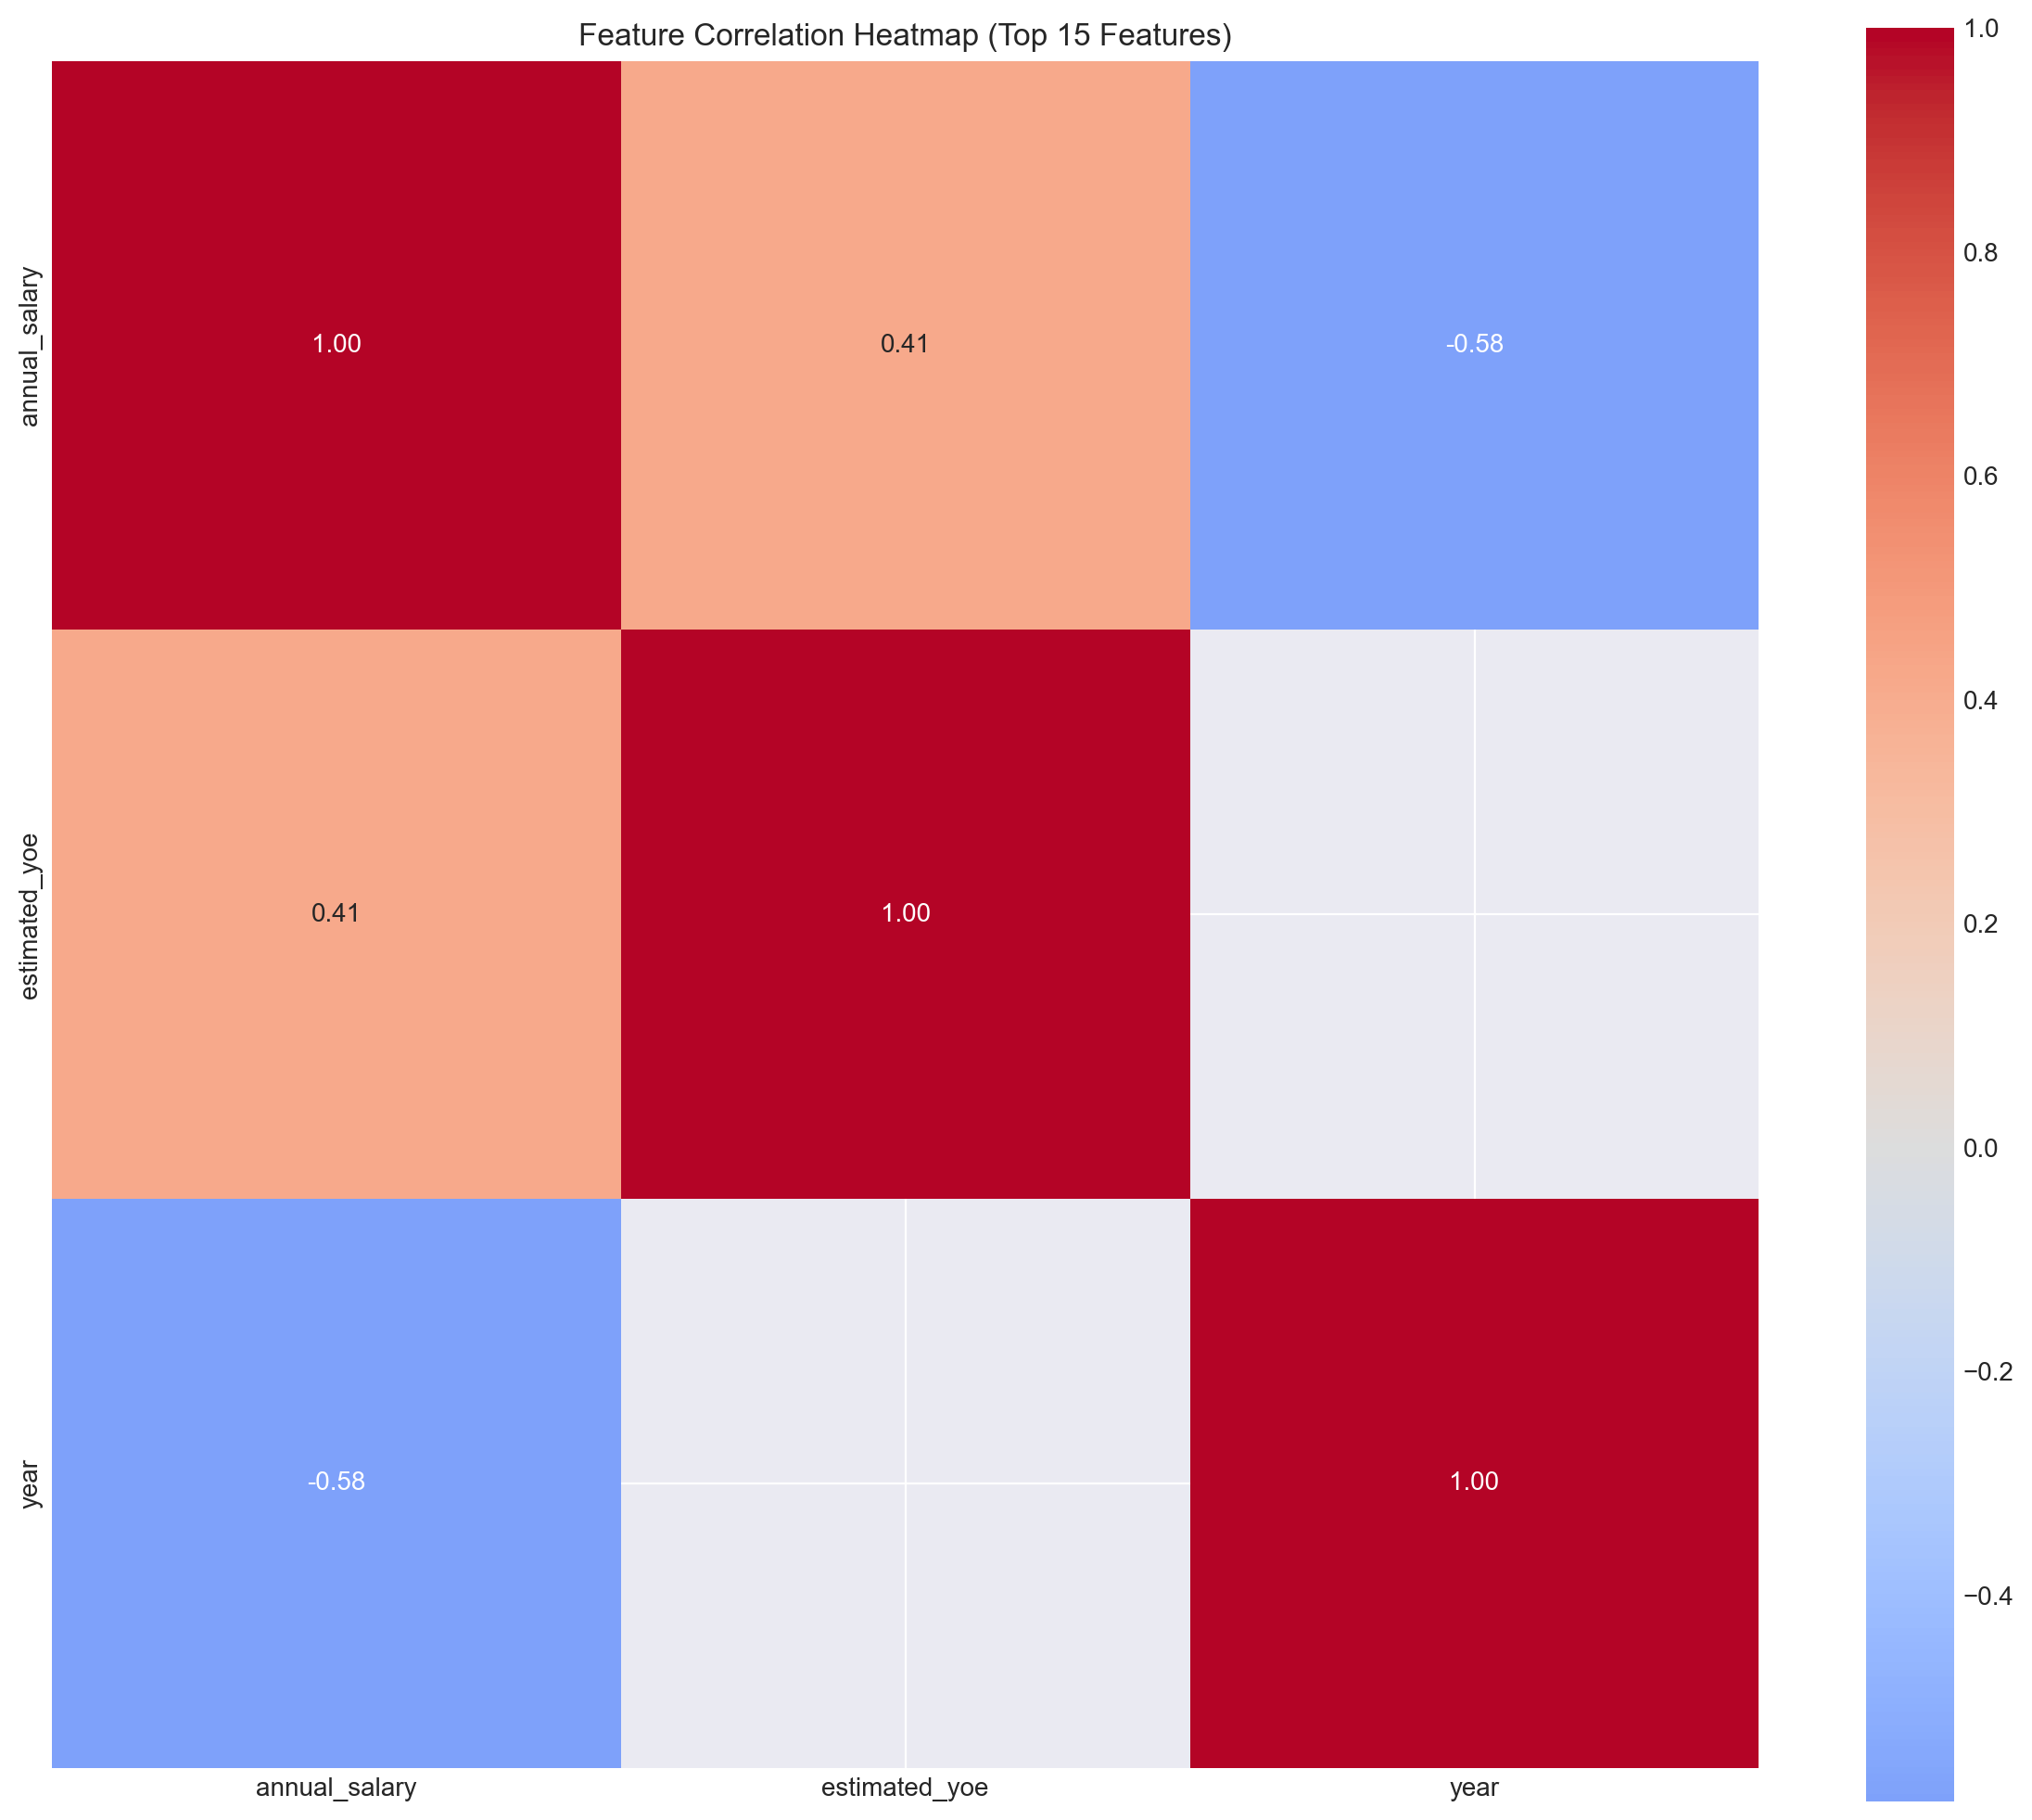

In [21]:
if merged_df is not None:
    print("\nMerged Dataset Analysis")
    print("="*60)
    
    # Records by source
    if 'data_source' in merged_df.columns:
        print("\nRecords by Data Source:")
        source_counts = merged_df['data_source'].value_counts()
        print(source_counts)
        
        # Plot
        fig, ax = plt.subplots(figsize=(10, 6))
        source_counts.plot(kind='bar', ax=ax)
        ax.set_title('Record Count by Data Source (Merged Dataset)')
        ax.set_xlabel('Data Source')
        ax.set_ylabel('Number of Records')
        ax.grid(axis='y', alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    # Overall quality
    assess_data_quality(merged_df, "Merged Dataset")
    
    # Correlation analysis for numeric features
    numeric_cols = merged_df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols) > 1:
        print("\nCorrelation with Salary:")
        salary_col = get_salary_column(merged_df)
        if salary_col and salary_col in numeric_cols:
            correlations = merged_df[numeric_cols].corr()[salary_col].sort_values(ascending=False)
            print(correlations.head(20))
            
            # Plot correlation heatmap
            fig, ax = plt.subplots(figsize=(12, 10))
            # Select top correlated features
            top_features = correlations.head(15).index.tolist()
            corr_matrix = merged_df[top_features].corr()
            
            sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                       center=0, ax=ax, square=True)
            ax.set_title('Feature Correlation Heatmap (Top 15 Features)')
            plt.tight_layout()
            plt.show()
else:
    print("\nNo merged dataset available. Run the merge command to create one.")
    print("Command: python -m src.main merge")

## 9. Key Findings & Recommendations

Based on the EDA, summarize the most valuable features for the model.

In [22]:
print("\n" + "="*80)
print("KEY FINDINGS & RECOMMENDATIONS")
print("="*80)

print("""
### Data Source Summary:

1. **H1B Data**: 
   - Large dataset with government-verified salary data
   - Strong on: employer_name, worksite_state, job_title, soc_code
   - Weakness: No skills data, limited to H1B roles

2. **BLS Data**:
   - Reliable wage statistics by occupation
   - Strong on: Occupation-level benchmarks
   - Weakness: Aggregated data, less granular

3. **Adzuna Data**:
   - Job posting data with salary ranges
   - Strong on: Current market trends
   - Weakness: Variable data quality, some missing salaries

4. **LinkedIn Data**:
   - Rich feature set with skills, education, experience
   - Strong on: skills, seniority_level, job_function, education
   - Weakness: Smaller sample size, salary data completeness

### Most Valuable Features for Model:

**High Value:**
- job_title (available in all sources)
- worksite_state/location (strong salary predictor)
- skills (unique to LinkedIn, high predictive value)
- seniority_level (when available)
- estimated_yoe/experience_years (strong correlation)

**Medium Value:**
- employer_name/company (useful for company tier)
- education (when available)
- soc_code (useful for standardization)
- employment_type

**Consider Engineering:**
- Company tier (from employer_name)
- Job level (from job_title parsing: junior/senior/lead/principal)
- Skill categories (group related skills)
- Metro area (from location)

### Recommendations:

1. **Prioritize LinkedIn data** for training when skills matter
2. **Use H1B data** as the backbone for large-scale training
3. **Feature engineering** is critical - extract seniority, clean titles
4. **Location encoding** is essential - state has high predictive value
5. **Handle missing data** carefully - different strategies per feature
6. **Consider ensemble approach** - different models for different data sources
""")

print("\n" + "="*80)


KEY FINDINGS & RECOMMENDATIONS

### Data Source Summary:

1. **H1B Data**: 
   - Large dataset with government-verified salary data
   - Strong on: employer_name, worksite_state, job_title, soc_code
   - Weakness: No skills data, limited to H1B roles

2. **BLS Data**:
   - Reliable wage statistics by occupation
   - Strong on: Occupation-level benchmarks
   - Weakness: Aggregated data, less granular

3. **Adzuna Data**:
   - Job posting data with salary ranges
   - Strong on: Current market trends
   - Weakness: Variable data quality, some missing salaries

4. **LinkedIn Data**:
   - Rich feature set with skills, education, experience
   - Strong on: skills, seniority_level, job_function, education
   - Weakness: Smaller sample size, salary data completeness

### Most Valuable Features for Model:

**High Value:**
- job_title (available in all sources)
- worksite_state/location (strong salary predictor)
- skills (unique to LinkedIn, high predictive value)
- seniority_level (when availa

## 10. Export Summary Report

In [23]:
# Create a summary report
summary = {
    'timestamp': pd.Timestamp.now().isoformat(),
    'data_sources': {
        'h1b': {'records': len(h1b_df), 'columns': list(h1b_df.columns)},
        'bls': {'records': len(bls_df), 'columns': list(bls_df.columns)},
        'adzuna': {'records': len(adzuna_df), 'columns': list(adzuna_df.columns)},
        'linkedin': {'records': len(linkedin_df), 'columns': list(linkedin_df.columns)}
    },
    'salary_statistics': salary_stats,
    'feature_availability': {
        'h1b': list(h1b_features.keys()),
        'bls': list(bls_features.keys()),
        'adzuna': list(adzuna_features.keys()),
        'linkedin': list(linkedin_features.keys())
    }
}

# Save summary
output_dir = Path('../docs')
output_dir.mkdir(exist_ok=True)
summary_path = output_dir / 'eda_summary.json'

with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2, default=str)

print(f"\nSummary report saved to: {summary_path}")


Summary report saved to: ../docs/eda_summary.json
